## MLP 기본 만들기

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

# STEP 01
1) Torch.cuda.is_available() : 가능한 gpu가 있는지 확인해서 train에 이용할 device 결정\
2) BATCH_SIZE, EPOCHS 등 하이퍼파라미터 결정

In [3]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')

print('Using PyTorch version  : ', torch.__version__, ' Device : ', DEVICE)

Using PyTorch version  :  1.9.0+cu111  Device :  cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 30

# STEP 02
1) dataset 과 dataloader 준비
2) 데이터 확인하기

In [5]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              download = True,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

/home/kist/anaconda3/envs/sj/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
for (X_train, y_train) in train_loader :
    print('X_train : ', X_train.size(), ' type : ', X_train.type())
    print('y_train : ', y_train.size(), ' type : ', y_train.type())
    break

X_train :  torch.Size([32, 1, 28, 28])  type :  torch.FloatTensor
y_train :  torch.Size([32])  type :  torch.LongTensor


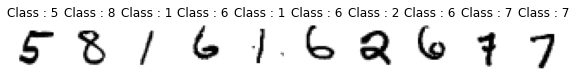

In [7]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Class : ' + str(y_train[i].item()))

# STEP 03
1) 모델 구조 정의하기
2) optimizer, loss function 정의하기

In [10]:
class Net(nn.Module) :
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5 # 50%의 노드에 대해 weights 계산하지 않음
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x) # batch normalization : activation function 앞 뒤에 batch_norm을 할 지는 연구자마다 갈림
        x = F.relu(x) # activation function : ReLU
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # self.training = True 일 때 만, 즉 학습 할 때만 dropout 적용하기

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.dropout_prob)

        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [11]:
import torch.nn.init as init

#He Initialization 을 이용해서 weight 초기화 하기
def weight_init(m) : # model 내에서 weight 초기화할 부분을 정하기 위한 함수
    if isinstance(m, nn.Linear) : # 모델 내 파라미터들 중에서 nn.Linear 의 weight만 지정
        init.kaiming_uniform_(m.weight.data) # nn.Linear 파라미터에 대해서 He Initialization 진행

model = Net().to(DEVICE)
model.apply(weight_init)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # optimizer 를 Adam 으로 진행
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# STEP 04
- train 코드

In [12]:
def train(model, train_loader, optimizer, log_interval) :
    model.train() # model의 상위 클래스 속 변수 self.training = True 로 만들어주기
    for batch_idx, (image, label) in enumerate(train_loader) :
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)

        loss = criterion(output, label)
        optimizer.zero_grad() # 이전에 학습할 때 저장된 gradient 없애기
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [ {}/{} ({:.0f}%) ]\tTrain Loss : {:.6f}".format(
                Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

# STEP 05
- evaluate 코드

In [13]:
def evaluate(model, test_loader) :
    model.eval() # model의 상위 클래스 속 변수 self.training = False 로 만들어주기
    test_loss = 0
    correct = 0

    with torch.no_grad() : #train 단계가 아니라 eval 단계이므로 gradient update 못하게 방지
        for image, label in test_loader :
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, test_accuracy

#STEP 06
- Train 및 Test 하기

In [14]:
for Epoch in range(1, EPOCHS+1) :
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[Epochh : {}], \tTest Loss : {:.4f}, \tTest Accurary : {:.2f} % \n"
        .format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [ 0/60000 (0%) ]	Train Loss : 2.984270
Train Epoch : 1 [ 6400/60000 (11%) ]	Train Loss : 0.341239
Train Epoch : 1 [ 12800/60000 (21%) ]	Train Loss : 0.263182
Train Epoch : 1 [ 19200/60000 (32%) ]	Train Loss : 0.365248
Train Epoch : 1 [ 25600/60000 (43%) ]	Train Loss : 0.548437
Train Epoch : 1 [ 32000/60000 (53%) ]	Train Loss : 0.095029
Train Epoch : 1 [ 38400/60000 (64%) ]	Train Loss : 0.275530
Train Epoch : 1 [ 44800/60000 (75%) ]	Train Loss : 0.377446
Train Epoch : 1 [ 51200/60000 (85%) ]	Train Loss : 0.429867
Train Epoch : 1 [ 57600/60000 (96%) ]	Train Loss : 0.154104

[Epochh : 1], 	Test Loss : 0.0039, 	Test Accurary : 96.12 % 

Train Epoch : 2 [ 0/60000 (0%) ]	Train Loss : 0.245688
Train Epoch : 2 [ 6400/60000 (11%) ]	Train Loss : 0.159858
Train Epoch : 2 [ 12800/60000 (21%) ]	Train Loss : 0.113497
Train Epoch : 2 [ 19200/60000 (32%) ]	Train Loss : 0.183045
Train Epoch : 2 [ 25600/60000 (43%) ]	Train Loss : 0.558814
Train Epoch : 2 [ 32000/60000 (53%) ]	Train Loss 